## implementing Arima Sarima smoothing

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [29]:
df = pd.read_csv('/content/data_sales.csv')
df.head(10)

,date,store,item,sales,f0,f1
0,01-01-2013,1,1,13.0,9.0,NaN
1,02-01-2013,1,1,11.0,NaN,NaN
2,03-01-2013,1,1,14.0,NaN,NaN
3,04-01-2013,1,1,13.0,NaN,NaN
4,05-01-2013,1,1,10.0,NaN,NaN
5,06-01-2013,1,1,12.0,NaN,NaN
6,07-01-2013,1,1,10.0,2.0,NaN
7,08-01-2013,1,1,9.0,3.0,NaN
8,09-01-2013,1,1,12.0,4.0,NaN
9,10-01-2013,1,1,9.0,9.0,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912943 non-null  float64
 4   f0      41 non-null      float64
 5   f1      41 non-null      float64
dtypes: float64(3), int64(2), object(1)
memory usage: 41.8+ MB


In [31]:
df.describe()

,store,item,sales,f0,f1
count,913000.000000,913000.000000,912943.000000,41.000000,41.000000
mean,5.500000,25.500000,52.251626,5.170732,5.365854
std,2.872283,14.430878,28.801046,2.290223,2.556913
min,1.000000,1.000000,0.000000,2.000000,2.000000
25%,3.000000,13.000000,30.000000,3.000000,3.000000
50%,5.500000,25.500000,47.000000,5.000000,5.000000
75%,8.000000,38.000000,70.000000,7.000000,7.000000
max,10.000000,50.000000,231.000000,9.000000,9.000000


In [32]:
df.isnull().sum()

date          0
store         0
item          0
sales        57
f0       912959
f1       912959
dtype: int64

In [33]:
df.columns

Index(['date', 'store', 'item', 'sales', 'f0', 'f1'], dtype='object')

##Data Cleaning

In [34]:
#so we can see f1 and f0 has more nan
df.drop(['f0', 'f1'], axis=1, inplace=True)

In [35]:
df.sample(10)

,date,store,item,sales
751381,15-06-2015,2,42,48.0
407677,25-04-2014,4,23,32.0
220624,13-02-2017,1,13,48.0
323171,01-12-2017,7,18,44.0
866676,27-02-2016,5,48,51.0
376294,19-05-2013,7,21,25.0
70851,03-01-2017,9,4,10.0
201430,25-07-2014,1,12,81.0
721437,17-06-2013,6,40,16.0
773830,03-12-2016,4,43,54.0


In [36]:
print(f'shape is {df.shape}\n')
df.info()

shape is (913000, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912943 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [37]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   912943 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.9 MB


In [39]:
print(df.describe())
print('\n')
print(f' checking null values \n {df.isnull().sum()}')

                                date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 11:59:59.999999744       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-04-02 00:00:00       3.000000      13.000000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
75%              2016-10-01 00:00:00       8.000000      38.000000   
max              2017-12-31 00:00:00      10.000000      50.000000   
std                              NaN       2.872283      14.430878   

               sales  
count  912943.000000  
mean       52.251626  
min         0.000000  
25%        30.000000  
50%        47.000000  
75%        70.000000  
max       231.000000  
std        28.801046  


 checking null values 
 date      0
store     0
item      0
sales    57
dtype: int64


In [40]:
print(df.columns)

# If the 'date' column is missing, you'll need to investigate why and potentially load or recreate it.
# If it's present but has a different name, adjust the code below accordingly.

if 'date' in df.columns:
    df = df.set_index('date')
    df = df.interpolate()
else:
    print("Error: 'date' column not found in DataFrame.")


Index(['date', 'store', 'item', 'sales'], dtype='object')


In [43]:
df = df.reset_index(drop=False)
df.head(10)

,level_0,index,date,store,item,sales
0,0,0,2013-01-01,1,1,13.0
1,1,1,2013-01-02,1,1,11.0
2,2,2,2013-01-03,1,1,14.0
3,3,3,2013-01-04,1,1,13.0
4,4,4,2013-01-05,1,1,10.0
5,5,5,2013-01-06,1,1,12.0
6,6,6,2013-01-07,1,1,10.0
7,7,7,2013-01-08,1,1,9.0
8,8,8,2013-01-09,1,1,12.0
9,9,9,2013-01-10,1,1,9.0


In [44]:
df.isnull().sum()

level_0    0
index      0
date       0
store      0
item       0
sales      0
dtype: int64

In [45]:
df.sort_values(by='date', ascending = True, inplace = True)

In [46]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,level_0,index,store,item,sales,year,month,day,weekday
0,2013-01-01,0,0,1,1,13.0,2013,1,1,1
1,2013-01-02,1,1,1,1,11.0,2013,1,2,2
2,2013-01-03,2,2,1,1,14.0,2013,1,3,3
3,2013-01-04,3,3,1,1,13.0,2013,1,4,4
4,2013-01-05,4,4,1,1,10.0,2013,1,5,5


In [47]:
test_df.head()

,date,level_0,index,store,item,sales,year,month,day,weekday
0,2017-10-01,1734,1734,1,1,21.0,2017,10,1,6
1,2017-10-02,1735,1735,1,1,12.0,2017,10,2,7
2,2017-10-03,1736,1736,1,1,18.0,2017,10,3,1
3,2017-10-04,1737,1737,1,1,15.0,2017,10,4,2
4,2017-10-05,1738,1738,1,1,20.0,2017,10,5,3


<Axes: xlabel='year', ylabel='sales'>

<Figure size 1000x600 with 0 Axes>

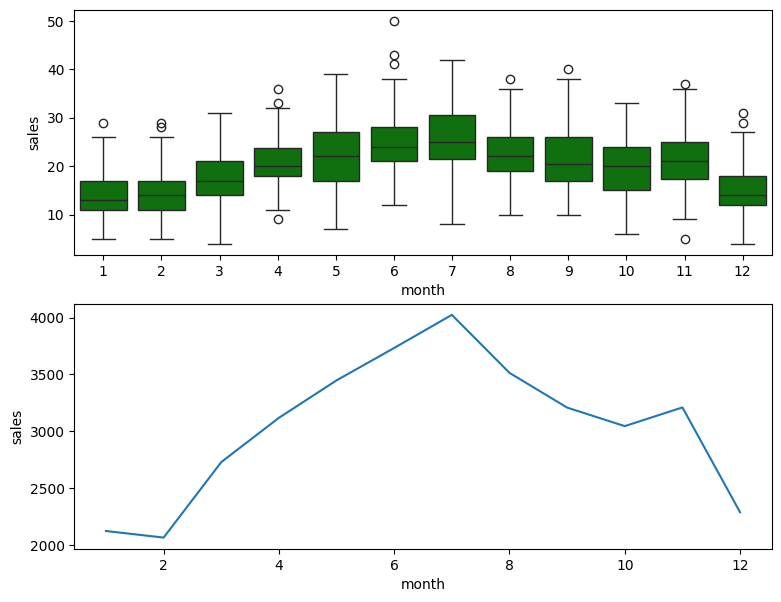

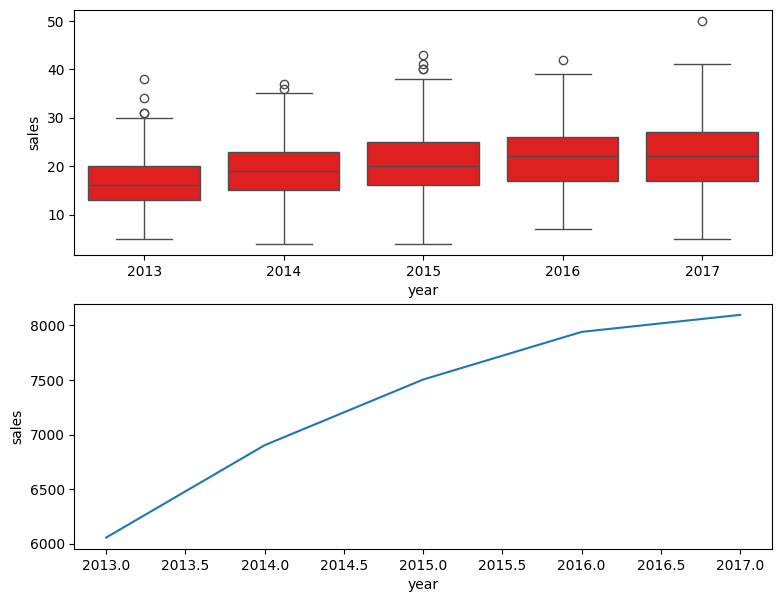

In [53]:
plt.figure(figsize=(10,6))

monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='sales', data=df, ax=axs[0], color='green')
sns.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])


yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='sales', data=df, ax=axs[0] ,color='red')
sns.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

[Text(0.5, 1.0, 'Sales for Store 1, Item 1 over the years')]

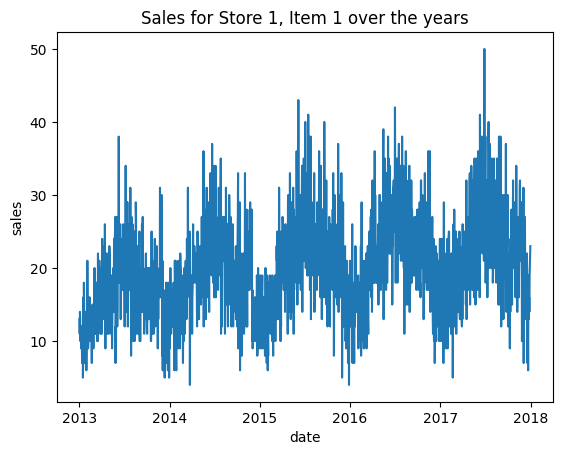

In [54]:
plot = sns.lineplot(x='date', y='sales', data=df)
plot.set(title='Sales for Store 1, Item 1 over the years')

##Decomposition

In [55]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,level_0,index,store,item,sales,year,month,day,weekday
date,,,,,,,,,
2013-01-01,0,0,1,1,13.0,2013,1,1,1
2013-01-02,1,1,1,1,11.0,2013,1,2,2
2013-01-03,2,2,1,1,14.0,2013,1,3,3
2013-01-04,3,3,1,1,13.0,2013,1,4,4
2013-01-05,4,4,1,1,10.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

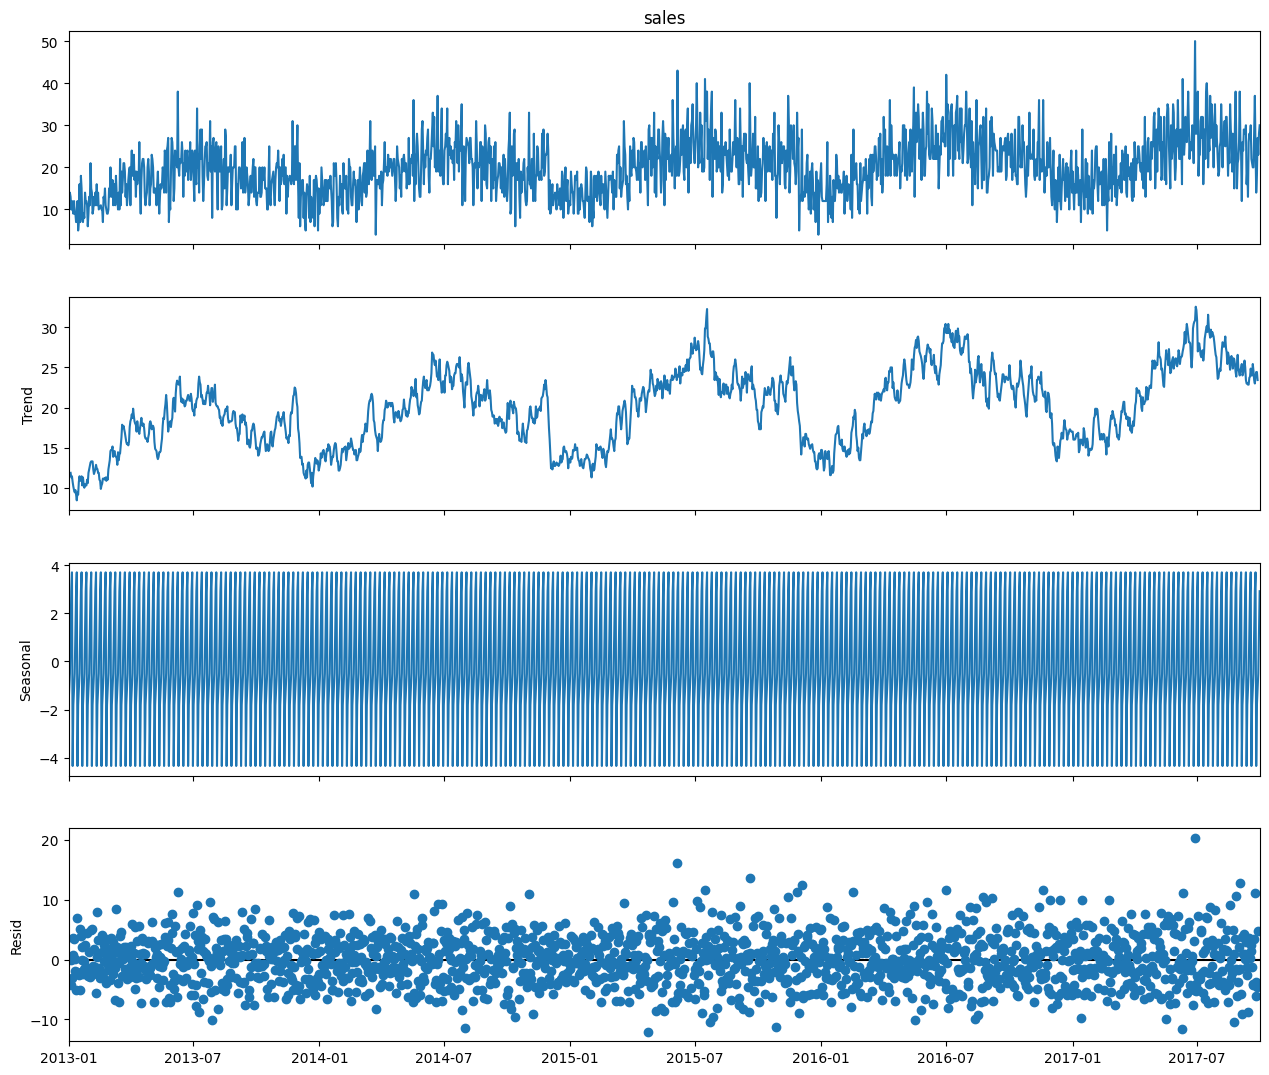

In [56]:
# Infer the frequency of the data
result = seasonal_decompose(ts_decomp_df['sales'], model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

##Smoothing

In [57]:
# single exponential smoothing holtwinters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [58]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')


In [59]:
hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


In [60]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


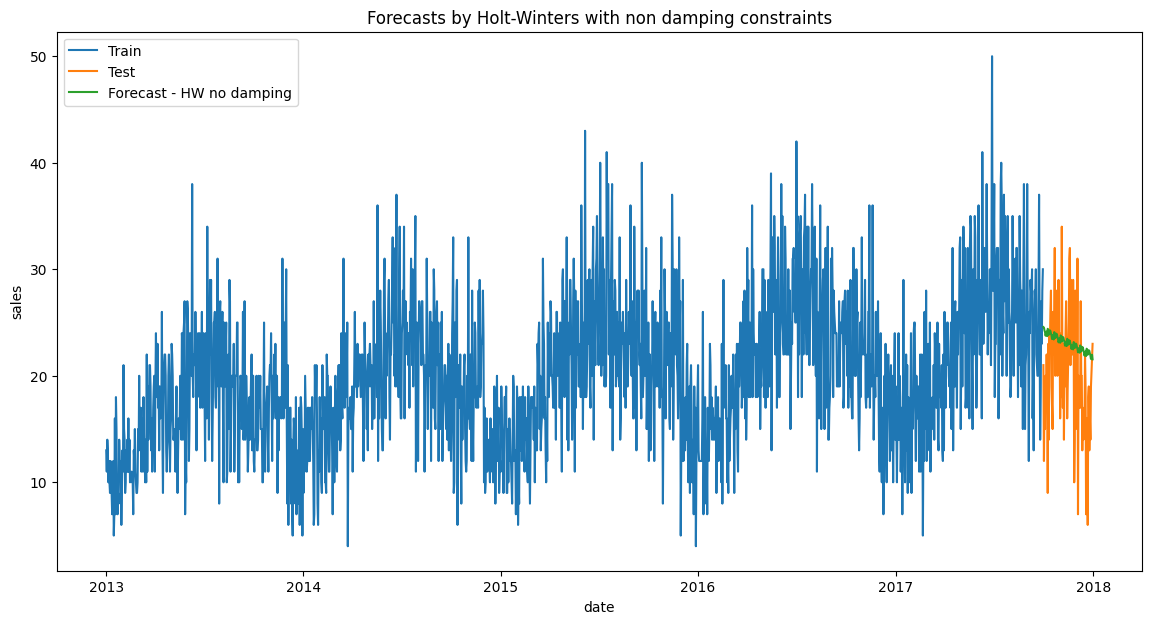

In [70]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts by Holt-Winters with non damping constraints')
plt.show()

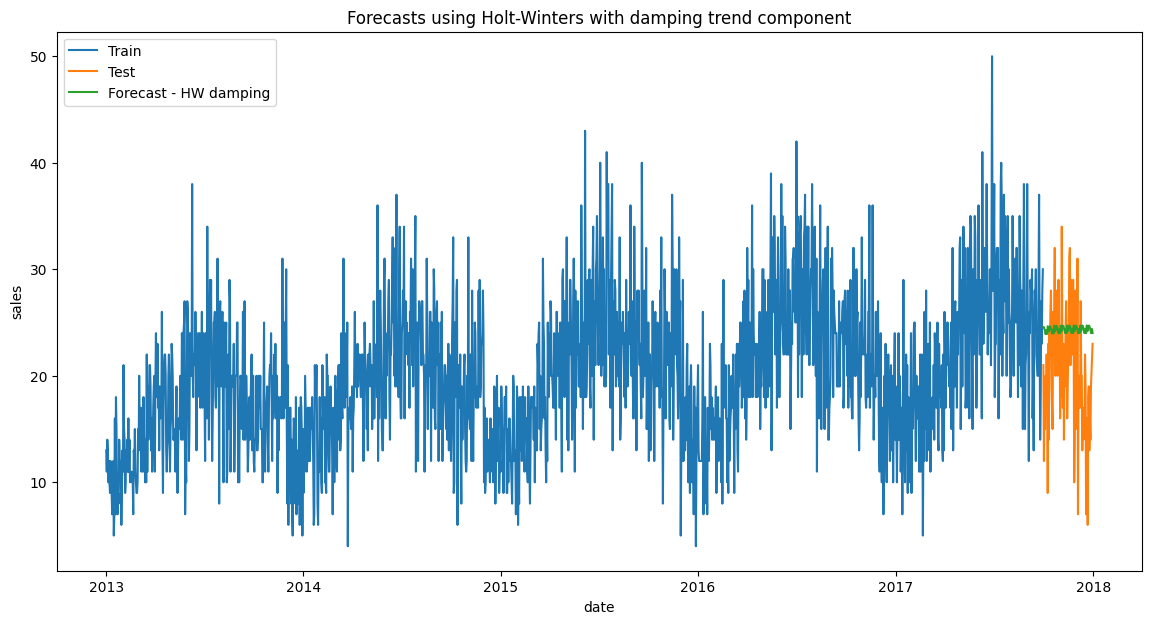

In [69]:
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()


##ARIMA SARIMA

In [74]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

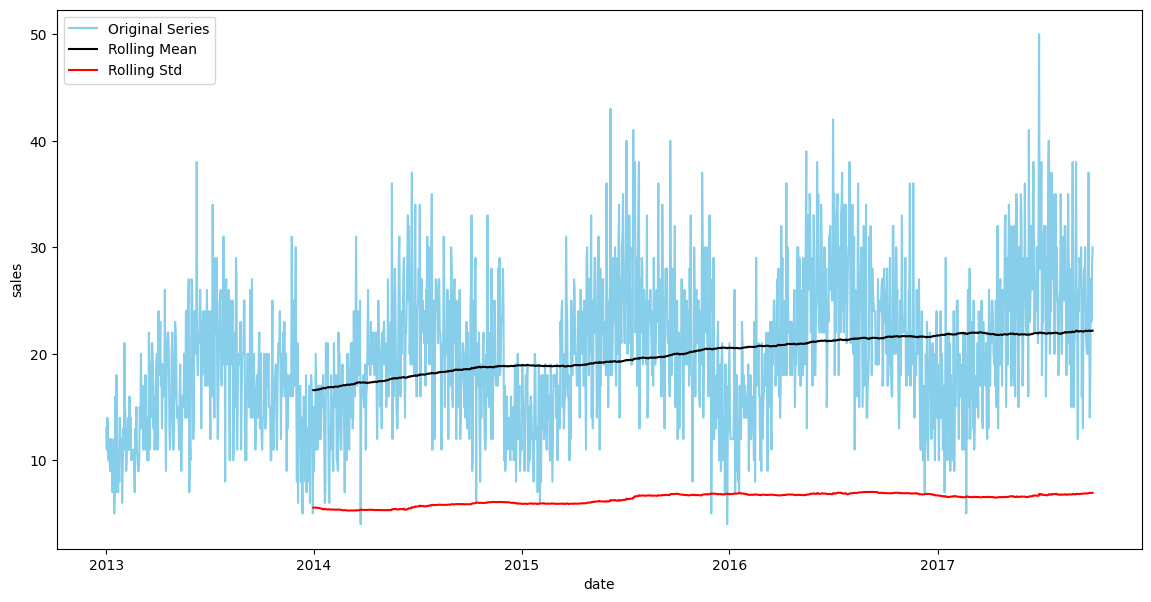

Test statistic = -3.066
P-value = 0.029
Critical values :
	1%: -3.4341843999399573 - The data is not stationary with 99% confidence
	5%: -2.8632336725104834 - The data is  stationary with 95% confidence
	10%: -2.567671665464627 - The data is  stationary with 90% confidence


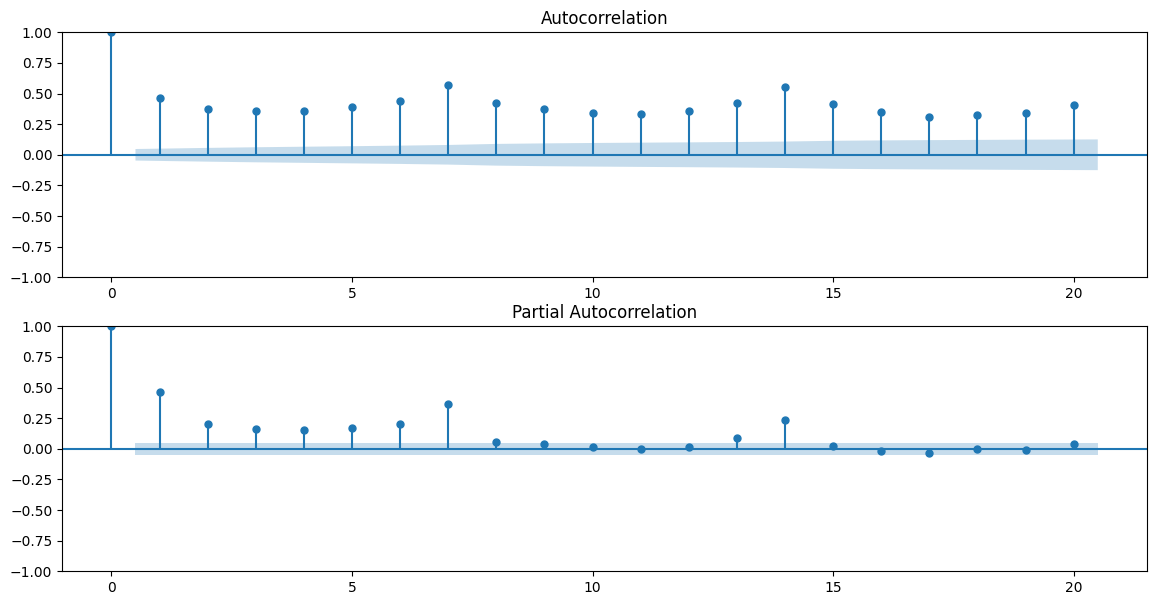

In [75]:
def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()

    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)

test_stationarity(arima_df.sales)

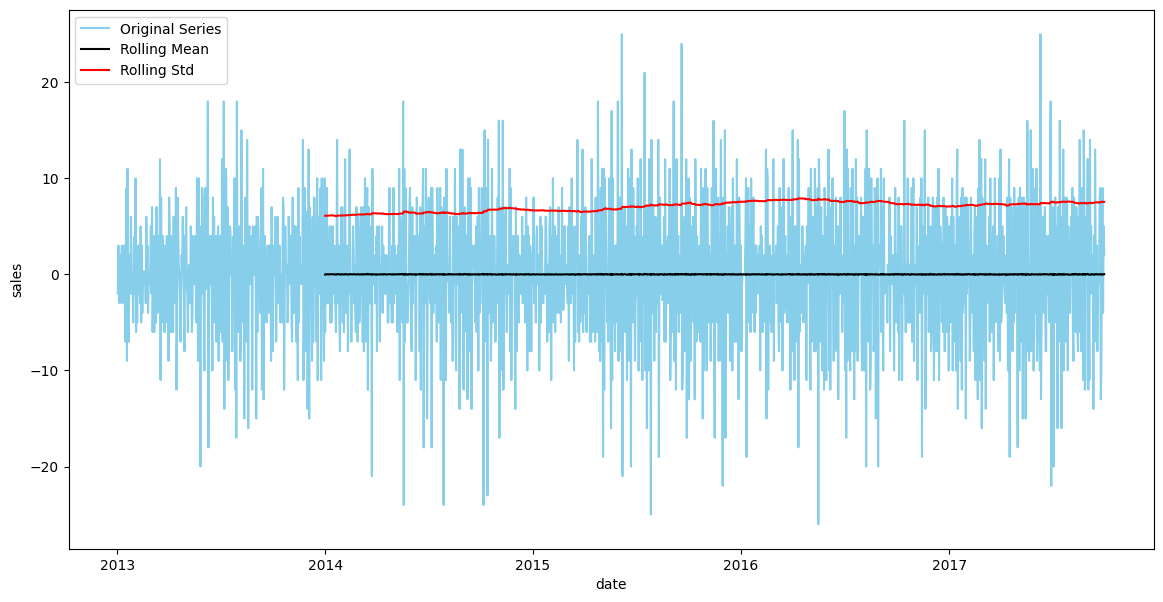

Test statistic = -12.305
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


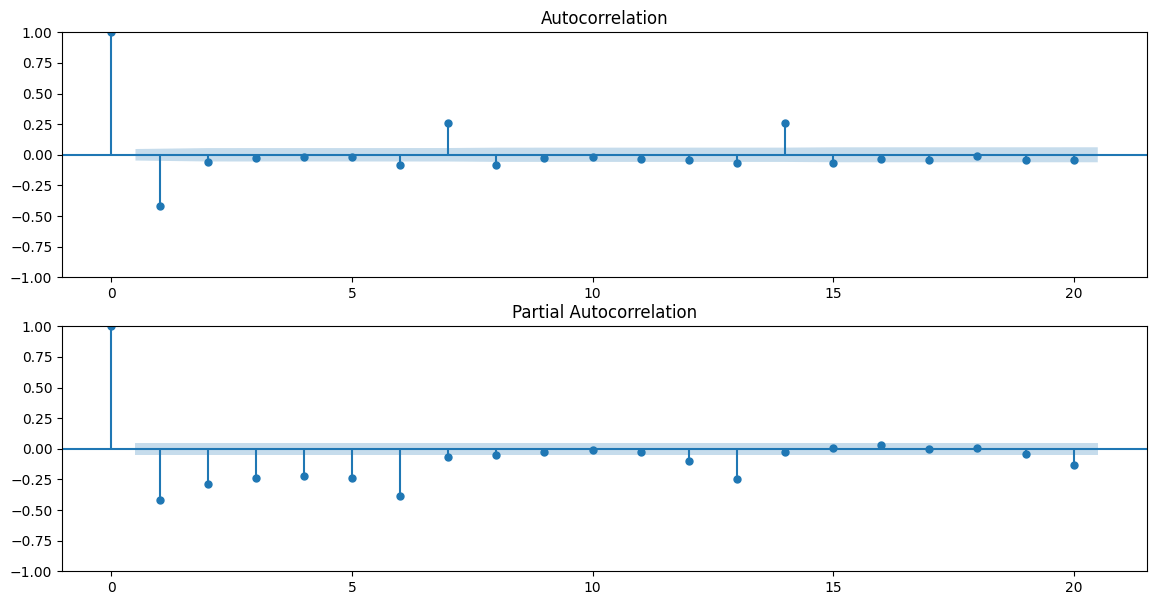

In [73]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
test_stationarity(first_difference.sales)

In [76]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(arima_df['sales'], order=(6, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5303.393
Date:                Wed, 19 Jun 2024   AIC                          10622.787
Time:                        19:33:51   BIC                          10666.448
Sample:                    01-01-2013   HQIC                         10638.935
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6076      0.052    -11.758      0.000      -0.709      -0.506
ar.L2         -0.6030      0.041    -14.780      0.000      -0.683      -0.523
ar.L3         -0.5646      0.037    -15.134      0.0

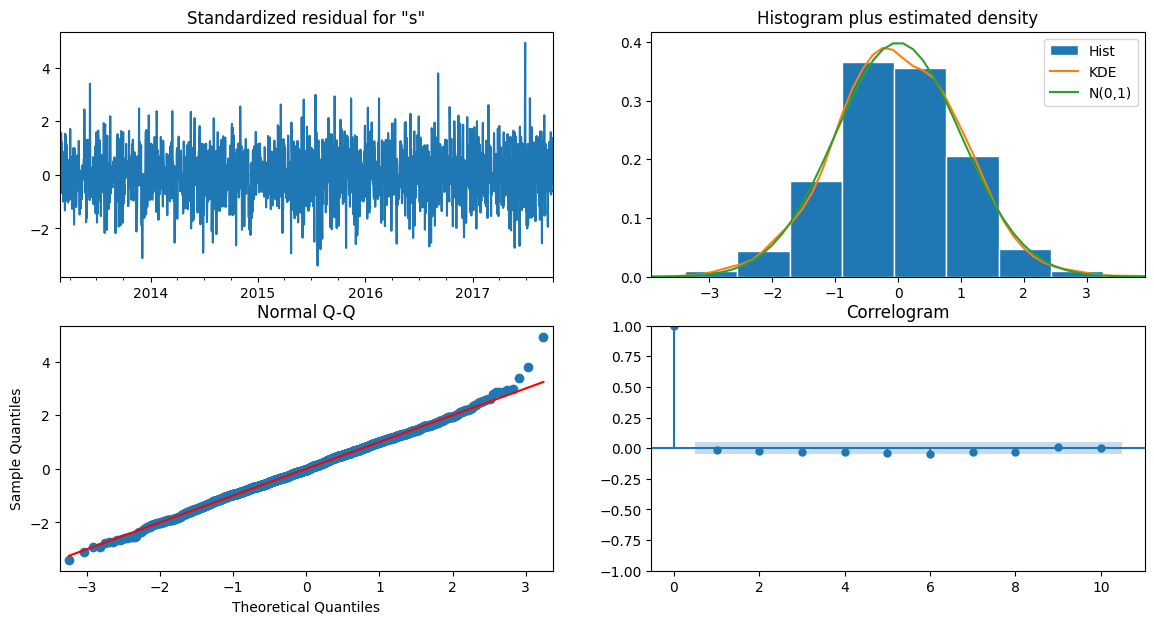

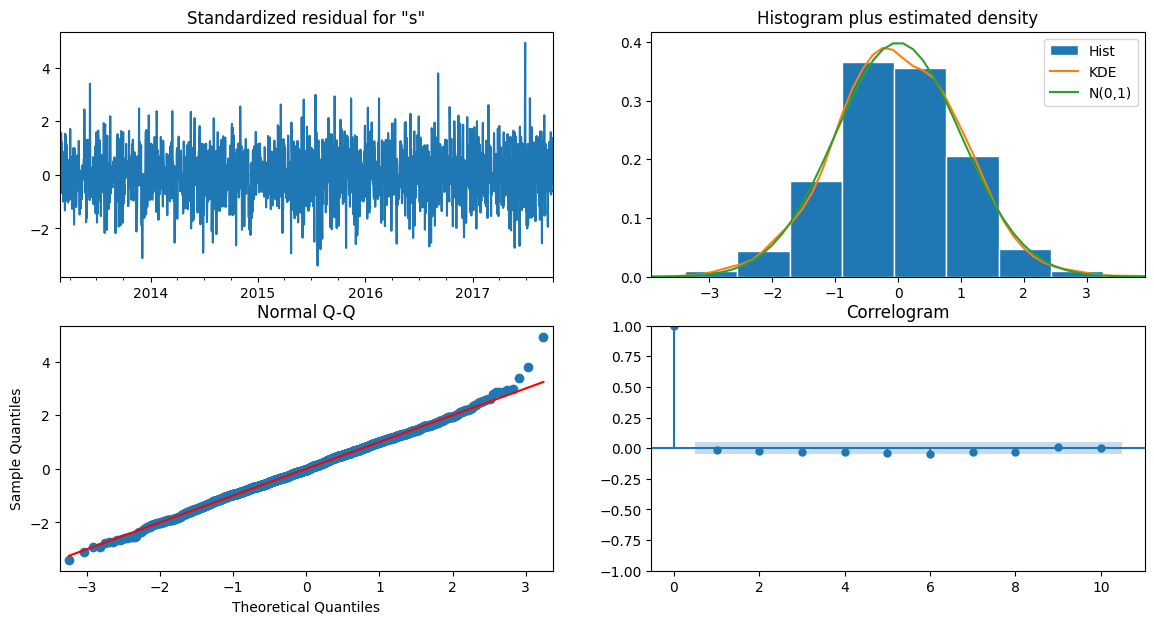

In [77]:
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

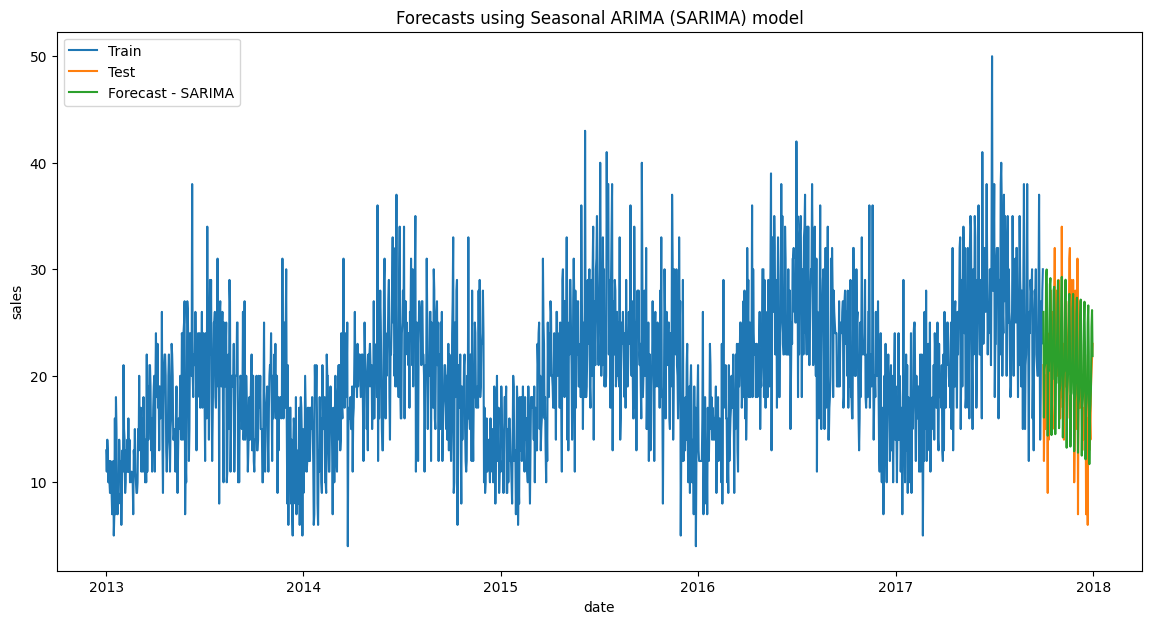

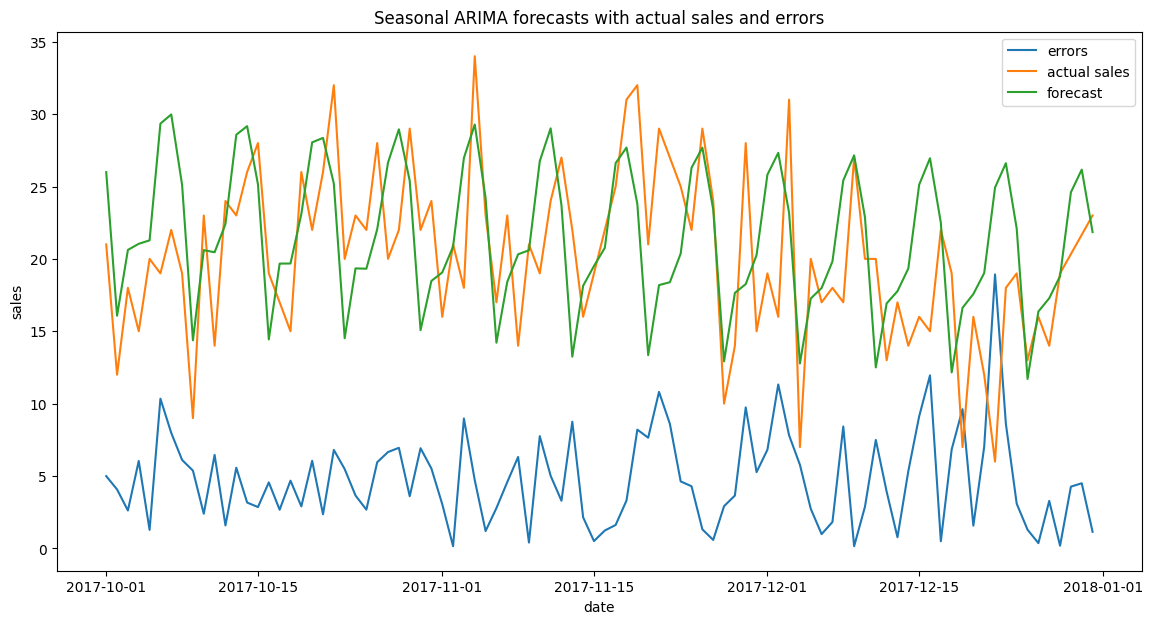

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error ,mean_absolute_percentage_error
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales


# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA forecasts with actual sales and errors')
plt.show()

In [85]:
result_df_sarima = pd.DataFrame({
    'total_sales': [arima_test_df['sales'].sum()],
    'total_pred_sales': [arima_test_df['pred_sales'].sum()],
    'SARIMA_overall_error': [arima_test_df['errors'].sum()],
    'MAE': [mean_absolute_error],
    'MAPE': [mean_absolute_percentage_error]
})

result_df_sarima

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,MAPE
0,1861.0,1974.96286,-113.96286,<function mean_absolute_error at 0x7aedad00e320>,<function mean_absolute_percentage_error at 0x...
